<a href="https://colab.research.google.com/github/5374m164a1l/CSE5045-Project/blob/master/Exploring_Pub_Finder_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q transformers
!pip install -q bert-tensorflow
#!pip install -q pyyaml h5py  # Required to save models in HDF5 format
!mkdir /content/training_1
%cd /content/training_1

     |████████████████████████████████| 757kB 2.7MB/s 
     |████████████████████████████████| 1.1MB 14.5MB/s 
     |████████████████████████████████| 3.0MB 20.7MB/s 
     |████████████████████████████████| 890kB 39.0MB/s 
     |████████████████████████████████| 71kB 2.1MB/s 
/content/training_1


In [ ]:
#!cat /usr/local/lib/python3.6/dist-packages/transformers/configuration_bert.py
#!cat /usr/local/lib/python3.6/dist-packages/bert/tokenization.py
#!cat /usr/local/lib/python3.6/dist-packages/tokenizers/implementations/bert_wordpiece.py

In [2]:
import warnings
warnings.filterwarnings("ignore")

import os, re
import math
import numpy as np
import pandas as pd
from tqdm import tqdm
tqdm.pandas()

import transformers
import tensorflow as tf
import tensorflow_hub as hub
import bert
from bert import tokenization

from tensorflow.keras.callbacks import Callback
from sklearn.metrics import accuracy_score, roc_auc_score
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger

from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tokenizers import BertWordPieceTokenizer
from tensorflow.keras.layers import Dense, Input, Dropout, Embedding
from tensorflow.keras.layers import LSTM, GRU, Conv1D, SpatialDropout1D

#from tensorflow.keras import layers
#from tensorflow.keras import optimizers
#from tensorflow.keras import activations
#from tensorflow.keras import constraints
#from tensorflow.keras import initializers
#from tensorflow.keras import regularizers

checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

np.random.seed(0)

print('\ndone')


done


In [3]:
DATA_PATH = "/content/drive/My Drive/pf_dsets/pf_subset"
NUMBER = "1"
PROC = "-processed-seqlen256.csv"
#PROC = ""
SOURCE_PATH = DATA_PATH + NUMBER + PROC
#VAL_PATH = DATA_PATH + "validation"+ PROC +".csv"
#TRAIN_PATH = DATA_PATH + "jigsaw-toxic-comment-train"+ PROC +".csv"

EPOCHS = 3
BATCH_SIZE = 16
#N_STEPS = 500
N_STEPS = 50
SEQUENCE_LENGTH = 256

pf_d1 = pd.read_csv(SOURCE_PATH)
#val_data = pd.read_csv(VAL_PATH)
#test_data = pd.read_csv(TEST_PATH)
#train_data = pd.read_csv(TRAIN_PATH)


print('\ndone')


done


In [4]:
def str2int(line):
  line = line.replace('(','')
  line = line.replace(')','')
  line = line.replace(',',' ')
  narray = line.split()
  return list(map(int, narray))
def convert(frame):
  lol = []
  for i in range(frame.shape[0]):
    lol.append(str2int(frame.iloc[i,3]))
  return np.asarray(lol,dtype=np.int32)
print('\ndone')


done


In [5]:
def get_tokenizer():#bert_path=BERT_PATH_SAVEDMODEL):
    """Get the tokenizer for a BERT layer."""
    #bert_path = "https://tfhub.dev/google/small_bert/bert_uncased_L-2_H-256_A-4/1"
    #bert_path = "https://tfhub.dev/tensorflow/bert_en_cased_L-24_H-1024_A-16/2"
    bert_path = "https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/2"
    bert_model = hub.keras_layer.load_module(bert_path)
    
    vocab_file = bert_model.vocab_file.asset_path.numpy()
    cased = bert_model.do_lower_case.numpy()
    tf.gfile = tf.io.gfile  # for bert.tokenization.load_vocab in tokenizer
    tokenizer = bert.tokenization.FullTokenizer(vocab_file, cased)
    #tokenizer = BertWordPieceTokenizer(vocab_file,lowercase=False)
  
    return tokenizer

tokenizer = get_tokenizer()

def process_sentence(sentence, max_seq_length=SEQUENCE_LENGTH, tokenizer=tokenizer):
    """ Converts sentence to ['input_word_ids', 'input_mask', 'segment_ids'] for BERT. """
    # Tokenize, and truncate to max_seq_length if necessary.
    tokens = tokenizer.tokenize(sentence)
    if len(tokens) > max_seq_length - 2:
        tokens = tokens[:(max_seq_length - 2)]

    # Convert the tokens in the sentence to word IDs.
    input_ids = tokenizer.convert_tokens_to_ids(["[CLS]"] + tokens + ["[SEP]"])

    # The mask has 1 for real tokens and 0 for padding tokens. Only real tokens are attended to.
    input_mask = [1] * len(input_ids)

    # Zero-pad up to the sequence length.
    pad_length = max_seq_length - len(input_ids)
    input_ids.extend([0] * pad_length)
    input_mask.extend([0] * pad_length)

    # We only have one input segment.
    segment_ids = [0] * max_seq_length

    return (input_ids, input_mask, segment_ids)
print('\ndone')

INFO:absl:Using /tmp/tfhub_modules to cache modules.
INFO:absl:Downloading TF-Hub Module 'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/2'.
INFO:absl:Downloaded https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/2, Total size: 417.01MB
INFO:absl:Downloaded TF-Hub Module 'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/2'.



done


In [6]:
AUTO = tf.data.experimental.AUTOTUNE

test_data = pf_d1.iloc[1:500,:]
val_data = pf_d1.iloc[500:2500,:]
train_data = pf_d1.iloc[2500:,:]

x_train = convert(train_data)
x_valid = convert(val_data)
x_test = convert(test_data)

#length of list equals number of samples, depth equals number of classes, result is shape (samples,classes)
y_valid = np.asarray(tf.one_hot(list(val_data.pubID.values),
                     depth=1370,
                     axis=-1,
                     dtype=tf.int32))

#y_valid = val_data.pubID.values
y_train = np.asarray(tf.one_hot(list(train_data.pubID.values),
                     depth=1370,
                     axis=-1,
                     dtype=tf.int32))
#need y_test for evaluate
y_test = np.asarray(tf.one_hot(list(test_data.pubID.values),
                     depth=1370,
                     axis=-1,
                     dtype=tf.int32))

train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_train, y_train))
    .repeat()
    .shuffle(2048)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)
valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_valid, y_valid))
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(x_test)
    .batch(BATCH_SIZE)
)

print('\ndone')


done


In [8]:
#important info here
def build_model(transformer, max_len=256):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    #something may be wrong here
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    cls_token = Dense(512, activation="hard_sigmoid")(cls_token)
    cls_token = Dropout(0.12)(cls_token)
    out = Dense(1370, activation='softmax')(cls_token)#can maybe try hard_sigmoid
    
    model = Model(inputs=input_word_ids, outputs=out)
    
    
    model.compile(Adam(lr=1.5e-1), #try 1.5e-2, originally 1.5e-5
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    
    return model
print('\ndone')

In [10]:
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
#many models to try here
transformer_layer = transformers.TFBertModel.\
    from_pretrained('bert-base-cased')
bert_model = build_model(transformer_layer, max_len=256)
bert_model.summary()


- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
If your task is similar to the task the model of the ckeckpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_word_ids (InputLayer)  [(None, 256)]             0         
_________________________________________________________________
tf_bert_model (TFBertModel)  ((None, 256, 768), (None, 108310272 
_________________________________________________________________
tf_op_layer_strided_slice (T [(None, 768)]             0         
_________________________________________________________________
dense (Dense)                (None, 512)               393728    
_________________________________________________________________
dropout_37 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1370)              702810    
Total params: 109,406,810
Trainable params: 109,406,810
Non-trainable params: 0
_______________________________________________

In [11]:
#need this whenever a change is made to the model
#directory is empty for first time run. To save weights, move the checkpoints off colab
bert_model.load_weights(checkpoint_path)
print('\ndone')

ValueError: ignored

In [ ]:
#bert_model.get_output_at(node_index=)
#bert_pred = bert_model.make_predict_function()

In [ ]:
#bert_model.load_weights(checkpoint_path)
#bert_model = tf.saved_model.load()

In [13]:
################--Run the model--################
train_history = bert_model.fit(
    train_dataset,
    steps_per_epoch=N_STEPS,
    validation_data=valid_dataset,
    callbacks=[cp_callback],
    epochs=EPOCHS
)
#need a way to have secondary loss (i.e. if correct label is not equal max of output but is in top 5 or 10, then scale down error)

Epoch 1/3
50/50 [==============================] - ETA: 0s - loss: 12.8308 - accuracy: 0.0125
Epoch 00001: saving model to training_1/cp.ckpt
50/50 [==============================] - 52s 1s/step - loss: 12.8308 - accuracy: 0.0125 - val_loss: 11.4453 - val_accuracy: 0.0025
Epoch 2/3
50/50 [==============================] - ETA: 0s - loss: 12.8670 - accuracy: 0.0225
Epoch 00002: saving model to training_1/cp.ckpt
50/50 [==============================] - 51s 1s/step - loss: 12.8670 - accuracy: 0.0225 - val_loss: 13.0772 - val_accuracy: 0.0600
Epoch 3/3
50/50 [==============================] - ETA: 0s - loss: 13.2847 - accuracy: 0.0113
Epoch 00003: saving model to training_1/cp.ckpt
50/50 [==============================] - 52s 1s/step - loss: 13.2847 - accuracy: 0.0113 - val_loss: 12.7629 - val_accuracy: 0.0125


In [ ]:
#we need only one configuration
#tf.saved_model.save(bert_model, checkpoint_dir)


In [ ]:
re_model = tf.saved_model.load(checkpoint_dir)
re_model.summary()


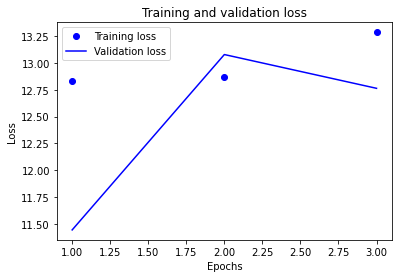

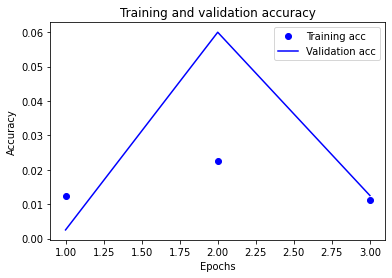

In [15]:
import matplotlib.pyplot as plt
#plotting
history_dict = train_history.history
history_dict.keys()

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
pf_d1.head()

In [16]:
original_text = pf_d1.iloc[23137,1]
#original_text = ""
new_word_vec = np.asarray(process_sentence(original_text)[0])
cartridge = (
    tf.data.Dataset
    .from_tensor_slices(new_word_vec.reshape(1,-1))
    .batch(1)
    #.prefetch(AUTO)
)
print('\ndone')


done


In [17]:
new_word_vec = np.asarray(new_word_vec)
print(new_word_vec.shape)
new_word_vec = new_word_vec.reshape(1,-1)
print(new_word_vec.shape)


(256,)
(1, 256)


In [18]:
#print(cartridge.shape)
print(cartridge.element_spec)
print(cartridge)

TensorSpec(shape=(None, 256), dtype=tf.int64, name=None)
<BatchDataset shapes: (None, 256), types: tf.int64>


In [19]:
prediction = bert_model.predict(cartridge)
print(prediction.shape)
#may be problem with input

(1, 1370)


In [20]:
prediction_copy = prediction.copy()
print(np.argmax(prediction_copy))

218


In [21]:
print(np.argmax(prediction_copy),np.argmax(prediction))

218 218


In [22]:
original_pubid = pf_d1.iloc[23137,0]
print(original_pubid)

1032


In [23]:
top5 = np.zeros((1,5),dtype=np.int16)
#top5 = np.zeros((1,5))
#
for i in range(5):
  idx = np.argmax(prediction)
  top5[0,i] = idx
  prediction[0,idx] = 0
print(top5)

[[ 218 1220  863 1288  659]]


In [ ]:
import tensorflow as tf
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

In [25]:
lookup = pd.read_csv('/content/drive/My Drive/pf_dsets/pf_lookup.csv')
print("Best match first:\n")
for i in range(5):
  print(lookup.iloc[top5[0,i],0])

Best match first:

BIOINFORMATICS
ACM TRANSACTIONS ON GRAPHICS
IEEE ACCESS
IEEE TRANSACTIONS ON SERVICES COMPUTING
COMPUTERS & INDUSTRIAL ENGINEERING
